In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emoji-data/train_emoji.csv
/kaggle/input/emoji-data/test_emoji.csv
/kaggle/input/glove6b50dtxt/glove.6B.50d.txt
/kaggle/input/emoji-dataset/Text_description.txt
/kaggle/input/emoji-dataset/Dataset.csv


In [2]:
# Libraries imporation
import numpy as np
import tensorflow
from keras.layers import Bidirectional
np.random.seed(0)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
import emoji
from keras.regularizers import l2
np.random.seed(1)
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from keras.preprocessing.text import Tokenizer
import spacy

# Data cleaning

In [3]:
train_data = pd.read_csv("/kaggle/input/emoji-data/train_emoji.csv")
test_data = pd.read_csv("/kaggle/input/emoji-data/test_emoji.csv")

In [4]:
# Check the number of Emotions
train_data['Label'].value_counts()

Label
1    335
2    324
0    324
4    288
3    268
Name: count, dtype: int64

In [5]:
#Check if there's null value
train_data.isnull().sum()

Sentence    0
Label       0
dtype: int64

In [6]:
# Print the shape of dataframe
print(train_data.shape)

(1539, 2)


# Tokenization and Preprocess

In [7]:
# It means small english language model and it help create nlp object from it
nlp = spacy.load("en_core_web_sm")

In [8]:
max_words = 80000  # Maximum number of words to keep based on word frequency

In [9]:
# use this utility function to get the preprocessed text data
def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

In [10]:
train_data['lemmatized_Sentence'] = train_data['Sentence'].apply(preprocess)
test_data['lemmatized_Sentence'] = test_data['Sentence'].apply(preprocess)

In [11]:
display(train_data)

,Sentence,Label,lemmatized_Sentence
0,I love the sound of your laughter,2,love sound laughter
1,The baseball game ended in a tie,1,baseball game end tie
2,Your smile is my favorite thing,2,smile favorite thing
3,The movie was a huge disappointment,3,movie huge disappointment
4,Let's have a feast at the new restaurant,4,let feast new restaurant
...,...,...,...
1534,The missed opportunities are disappointing,3,miss opportunity disappointing
1535,The lack of cooperation is disappointing,3,lack cooperation disappointing
1536,Excited for a delightful feast tonight,4,excited delightful feast tonight
1537,A warm smile is a sunbeam in the stormiest wea...,2,warm smile sunbeam stormy weather


In [12]:
X_train, Y_train = train_data['Sentence'], train_data['Label']
X_test, Y_test = test_data['Sentence'], test_data['Label']

# Transfer Y (train and test) into one-hot vector
Y_train_oh = pd.get_dummies(Y_train)
Y_test_oh = pd.get_dummies(Y_test)

In [13]:
Y_train

0       2
1       1
2       2
3       3
4       4
       ..
1534    3
1535    3
1536    4
1537    2
1538    3
Name: Label, Length: 1539, dtype: int64

In [14]:
Y_train_oh

,0,1,2,3,4
0,False,False,True,False,False
1,False,True,False,False,False
2,False,False,True,False,False
3,False,False,False,True,False
4,False,False,False,False,True
...,...,...,...,...,...
1534,False,False,False,True,False
1535,False,False,False,True,False
1536,False,False,False,False,True
1537,False,False,True,False,False


In [15]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train_oh, test_size=0.2)

# Training and Prediction

In [16]:
def read_glove_vecs(glove_file):
    # Open the GloVe file in read mode
    with open(glove_file, 'r') as f:
        words = set()  # Set to store unique words
        word_to_vec_map = {}  # Dictionary to store word vectors
        
        # Iterate through each line in the file
        for line in f:
            # Split the line into a list of words
            line = line.strip().split()
            
            # Extract the current word and its vector representation
            curr_word = line[0]
            
            # Add the current word to the set of unique words
            words.add(curr_word)
            
            # Store the vector representation of the current word in the dictionary
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}  # Dictionary to map words to indices
        index_to_words = {}  # Dictionary to map indices to words
        
        # Iterate through sorted unique words
        for w in sorted(words):
            # Map the current word to an index
            words_to_index[w] = i
            
            # Map the index to the current word
            index_to_words[i] = w
            
            i = i + 1
    
    # Return the dictionaries and the word vector map
    return words_to_index, index_to_words, word_to_vec_map

 #reading GloVe vectors from a file
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt')


In [17]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` 
    
    Arguments:
    X -- array of sentences (strings), of shape (m,)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence.    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]     # number of training examples\
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros([m,max_len])
    for i in range(m):
        # Convert the ith training sentence in lower case and split it into words.
        sentence_words = X.iloc[i].lower().split()
        j = 0
        # Loop over the words of sentence_words
        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1
    return X_indices

In [18]:
maxWords = len(max(train_data['Sentence'], key=len).split())

In [19]:
maxWords

18

# LSTM Model

In [20]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)
    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros([vocab_size,emb_dim])
    
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_size,emb_dim,trainable = False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) 
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [21]:
def Emojify_model(input_shape, word_to_vec_map, word_to_index):
    """
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # It should be of shape input_shape and dtype 'int32' .
    sentence_indices = Input(shape = input_shape , dtype = 'int32')
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128,return_sequences = True)(embeddings)

    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) 
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state.
    X = LSTM(units=128,return_sequences = False)(X)

    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) 
    # Propagate X through a Dense layer with 20 units
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
    
    return model

In [22]:
model = Emojify_model((maxWords,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding (Embedding)       (None, 18, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 18, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 18, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

In [23]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxWords)
X_validation_indices = sentences_to_indices(X_val, word_to_index, maxWords)

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_indices, y_train, epochs = 100, batch_size = 32, shuffle=True,callbacks = callback ,validation_data=(X_validation_indices, y_val))

Epoch 1/100
39/39 [==============================] - 9s 82ms/step - loss: 0.8791 - accuracy: 0.6726 - val_loss: 0.3631 - val_accuracy: 0.8571
Epoch 2/100
39/39 [==============================] - 2s 60ms/step - loss: 0.2628 - accuracy: 0.9123 - val_loss: 0.2385 - val_accuracy: 0.9221
Epoch 3/100
39/39 [==============================] - 2s 56ms/step - loss: 0.1835 - accuracy: 0.9383 - val_loss: 0.1834 - val_accuracy: 0.9513
Epoch 4/100
39/39 [==============================] - 2s 52ms/step - loss: 0.1321 - accuracy: 0.9545 - val_loss: 0.1863 - val_accuracy: 0.9448
Epoch 5/100
39/39 [==============================] - 2s 50ms/step - loss: 0.1125 - accuracy: 0.9610 - val_loss: 0.1712 - val_accuracy: 0.9448
Epoch 6/100
39/39 [==============================] - 2s 50ms/step - loss: 0.1157 - accuracy: 0.9643 - val_loss: 0.1891 - val_accuracy: 0.9513
Epoch 7/100
39/39 [==============================] - 2s 53ms/step - loss: 0.0887 - accuracy: 0.9724 - val_loss: 0.2306 - val_accuracy: 0.9318
Epoch 

In [25]:
loss = pd.DataFrame(model.history.history)
loss

,loss,accuracy,val_loss,val_accuracy
0,0.879111,0.672624,0.363140,0.857143
1,0.262788,0.912266,0.238478,0.922078
2,0.183545,0.938262,0.183392,0.951299
3,0.132124,0.954509,0.186272,0.944805
4,0.112506,0.961007,0.171202,0.944805
5,0.115738,0.964257,0.189107,0.951299
6,0.088676,0.972380,0.230630,0.931818
7,0.110480,0.961007,0.177599,0.948052
8,0.093959,0.969131,0.170976,0.961039
9,0.076317,0.974817,0.165044,0.944805


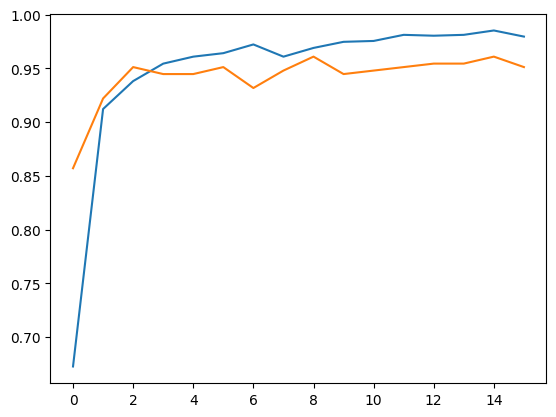

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(loss[["accuracy","val_accuracy"]])

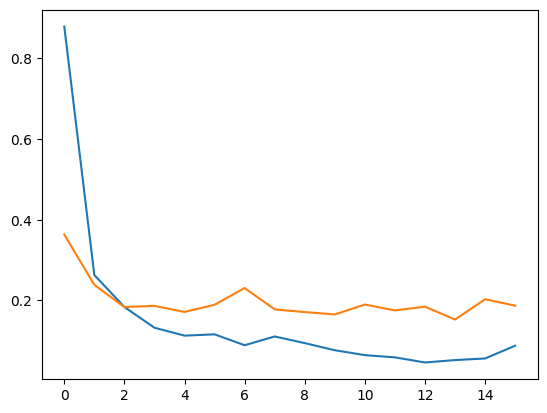

In [27]:
plt.plot(loss[["loss","val_loss"]])
plt.show()

In [28]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxWords)

In [29]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
pred = model.predict(X_test_indices)
print()
print("Test accuracy = ", acc)

4/4 [==============================] - 1s 18ms/step

Test accuracy =  0.7714285850524902


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

pred_labels = np.argmax(pred, axis=1)
print(classification_report(Y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.62      0.57        16
           1       0.88      1.00      0.94        15
           2       0.68      0.68      0.68        28
           3       0.91      0.74      0.82        27
           4       0.89      0.89      0.89        19

    accuracy                           0.77       105
   macro avg       0.78      0.79      0.78       105
weighted avg       0.78      0.77      0.77       105



In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Convert softmax probabilities to class labels
precision = precision_score(Y_test, pred_labels, average='weighted')
recall = recall_score(Y_test, pred_labels, average='weighted')
f1 = f1_score(Y_test, pred_labels, average='weighted')
conf_matrix = confusion_matrix(Y_test, pred_labels)
# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.7829
Recall: 0.7714
F1 Score: 0.7738
Confusion Matrix:
[[10  2  2  1  1]
 [ 0 15  0  0  0]
 [ 7  0 19  1  1]
 [ 2  0  5 20  0]
 [ 0  0  2  0 17]]


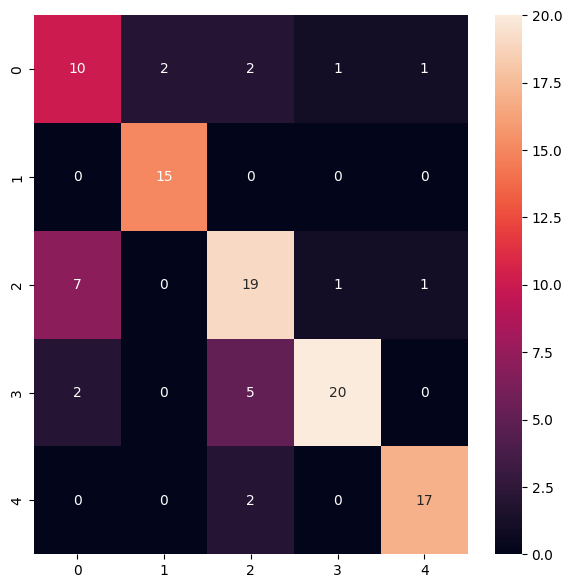

In [32]:
plt.figure(figsize=(7,7))
mat = confusion_matrix(Y_test, pred_labels)
sns.heatmap(mat, annot=True)                                                                   
plt.show()

In [33]:
model.save("model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
emoji_labels = {"0": ":heart_on_fire:",
                    "1": ":baseball:",
                    "2": ":grinning_face:",
                    "3": ":disappointed_face:",
                    "4": ":fork_and_knife:"}

In [35]:
def emoji_converter(label):
    return emoji.emojize(emoji_labels[str(label)])

In [36]:
for i in range(10,20):
    print(f"Real : {test_data.iloc[i]['Sentence']}{emoji_converter(Y_test[i])}")
    print(f"Predicted : {test_data.iloc[i]['Sentence']}{emoji_converter(np.argmax(pred[i]))}")
    print("----------------------------------------------------------------")

Real : where is the ball	⚾
Predicted : where is the ball	⚾
----------------------------------------------------------------
Real : work is hard	😞
Predicted : work is hard	😞
----------------------------------------------------------------
Real : This girl is messing with me	😞
Predicted : This girl is messing with me	❤️‍🔥
----------------------------------------------------------------
Real : are you serious😞
Predicted : are you serious😞
----------------------------------------------------------------
Real : Let us go play baseball	⚾
Predicted : Let us go play baseball	⚾
----------------------------------------------------------------
Real : This stupid grader is not working 	😞
Predicted : This stupid grader is not working 	😞
----------------------------------------------------------------
Real : work is horrible	😞
Predicted : work is horrible	😞
----------------------------------------------------------------
Real : Congratulation for having a baby	😀
Predicted : Congratulation for having

# Bi directional LSTM Model

In [37]:
def Emojify_modelv2(input_shape, word_to_vec_map, word_to_index):
    """
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # It should be of shape input_shape and dtype 'int32' .
    sentence_indices = Input(shape = input_shape , dtype = 'int32')
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = Bidirectional(LSTM(units=128, return_sequences=True))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) 
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state.
    X = Bidirectional(LSTM(units=128, return_sequences=False))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) 
    # Propagate X through a Dense layer with 5 units
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model2 = Model(inputs=sentence_indices,outputs=X)
    
    return model2

In [38]:
model2 = Emojify_modelv2((maxWords,), word_to_vec_map, word_to_index)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 18, 50)            20000050  
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               183296    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
 activation_1 (Activation)   (None, 5)                 0         
                                                           

In [39]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train_indices, y_train, epochs = 100, batch_size = 32, shuffle=True,validation_data=(X_validation_indices, y_val),callbacks = callback)

Epoch 1/100
39/39 [==============================] - 7s 59ms/step - loss: 0.8849 - accuracy: 0.6954 - val_loss: 0.3280 - val_accuracy: 0.8766
Epoch 2/100
39/39 [==============================] - 1s 34ms/step - loss: 0.2635 - accuracy: 0.9041 - val_loss: 0.1999 - val_accuracy: 0.9416
Epoch 3/100
39/39 [==============================] - 1s 32ms/step - loss: 0.1750 - accuracy: 0.9415 - val_loss: 0.1771 - val_accuracy: 0.9481
Epoch 4/100
39/39 [==============================] - 1s 32ms/step - loss: 0.1511 - accuracy: 0.9423 - val_loss: 0.1550 - val_accuracy: 0.9545
Epoch 5/100
39/39 [==============================] - 1s 32ms/step - loss: 0.1112 - accuracy: 0.9602 - val_loss: 0.1709 - val_accuracy: 0.9448
Epoch 6/100
39/39 [==============================] - 1s 32ms/step - loss: 0.0841 - accuracy: 0.9708 - val_loss: 0.1775 - val_accuracy: 0.9383
Epoch 7/100
39/39 [==============================] - 1s 32ms/step - loss: 0.0922 - accuracy: 0.9675 - val_loss: 0.1407 - val_accuracy: 0.9513
Epoch 

In [40]:
loss2, acc2 = model2.evaluate(X_test_indices, Y_test_oh)
pred2 = model2.predict(X_test_indices)
print()
print("Test accuracy = ", acc2)

4/4 [==============================] - 1s 10ms/step

Test accuracy =  0.7142857313156128


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

pred_labels2 = np.argmax(pred2, axis=1)
print(classification_report(Y_test, pred_labels2))

              precision    recall  f1-score   support

           0       0.45      0.62      0.53        16
           1       0.79      1.00      0.88        15
           2       0.72      0.46      0.57        28
           3       0.86      0.70      0.78        27
           4       0.75      0.95      0.84        19

    accuracy                           0.71       105
   macro avg       0.72      0.75      0.72       105
weighted avg       0.73      0.71      0.71       105



In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Convert softmax probabilities to class labels
precision2 = precision_score(Y_test, pred_labels2, average='weighted')
recall2 = recall_score(Y_test, pred_labels2, average='weighted')
f12 = f1_score(Y_test, pred_labels2, average='weighted')
conf_matrix2 = confusion_matrix(Y_test, pred_labels2)
# Print the results
print(f"Precision: {precision2:.4f}")
print(f"Recall: {recall2:.4f}")
print(f"F1 Score: {f12:.4f}")
print("Confusion Matrix:")
print(conf_matrix2)

Precision: 0.7324
Recall: 0.7143
F1 Score: 0.7079
Confusion Matrix:
[[10  1  2  1  2]
 [ 0 15  0  0  0]
 [ 8  1 13  2  4]
 [ 3  2  3 19  0]
 [ 1  0  0  0 18]]


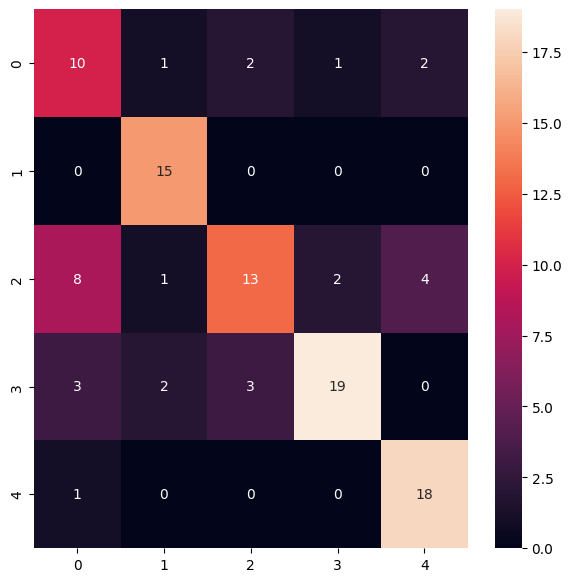

In [43]:
plt.figure(figsize=(7,7))
mat = confusion_matrix(Y_test, pred_labels2)
sns.heatmap(mat, annot=True)                                                                   
plt.show()

In [44]:
for i in range(10,20):
    print(f"Real : {test_data.iloc[i]['Sentence']}{emoji_converter(Y_test[i])}")
    print(f"Predicted : {test_data.iloc[i]['Sentence']}{emoji_converter(np.argmax(pred2[i]))}")
    print("----------------------------------------------------------------")

Real : where is the ball	⚾
Predicted : where is the ball	⚾
----------------------------------------------------------------
Real : work is hard	😞
Predicted : work is hard	❤️‍🔥
----------------------------------------------------------------
Real : This girl is messing with me	😞
Predicted : This girl is messing with me	❤️‍🔥
----------------------------------------------------------------
Real : are you serious😞
Predicted : are you serious😞
----------------------------------------------------------------
Real : Let us go play baseball	⚾
Predicted : Let us go play baseball	⚾
----------------------------------------------------------------
Real : This stupid grader is not working 	😞
Predicted : This stupid grader is not working 	😞
----------------------------------------------------------------
Real : work is horrible	😞
Predicted : work is horrible	😞
----------------------------------------------------------------
Real : Congratulation for having a baby	😀
Predicted : Congratulation for hav

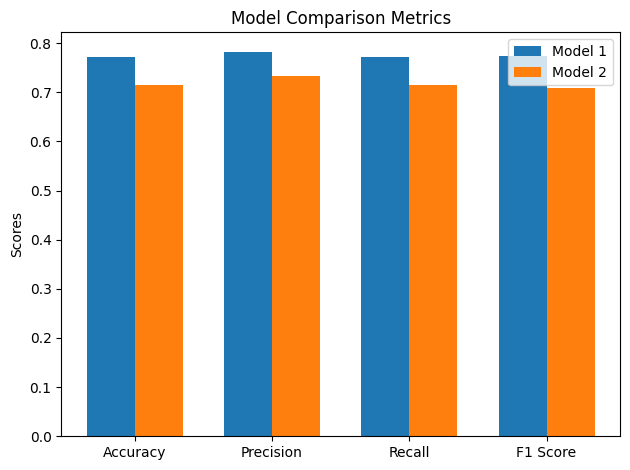

In [45]:
# Step 5: Compare and plot the results
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
model1_metrics = [acc, precision, recall, f1]
model2_metrics = [acc2, precision2, recall2, f12]

x = np.arange(len(labels))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, model1_metrics, width, label='Model 1')
rects2 = ax.bar(x + width/2, model2_metrics, width, label='Model 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Comparison Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()